# HMM build and analysis

Here we will construct and analyze HMM models using MSA as the input data. We will utilize several databases as sources to enhance our analysis and gain valuable insights from the generated HMM profiles.


In [1]:
import re
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import ipywidgets as widgets
from functions import get_fasta, process_hmmsearch_file

In [2]:
local_path = "/Users/alina/HMM/"

In [3]:
disordered = pd.read_csv("disordered_df.csv")
disordered.head(10)

,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score,count
0,Q9H832,A0A6J2FM24,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGAAGPGAS V GVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGAAGPGASGVTGVVGVSGSG--FGPPFLPD...,1,354,1,354,350,350,4,0.0,1851.0,200
1,Q9H832,A0A3Q7W6Y2,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGA GPGAS VAGVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGATGPGASGVAGVVGVSGSG--FGPPFLPD...,1,354,1,354,350,350,4,0.0,1851.0,200
2,Q9H832,A0A2U3VK69,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGAAGPGAS V GVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGAAGPGASGVTGVVGVSGSG--FGPPFLPD...,1,354,1,354,350,350,4,0.0,1851.0,200
3,Q9H832,A0A2Y9JVH5,354,358,MAESPTEEAATA----GAGAAGPGASSVAGVVGVSGSGGGFGPPFL...,MAESPTEEAATA GAGAAGPGAS VAGVVGVSGSG FGPPFL...,MAESPTEEAATATATAGAGAAGPGASGVAGVVGVSGSG--FGPPFL...,1,354,1,356,351,351,6,0.0,1854.0,200
4,Q9H832,A0A8C7ALE4,354,358,MAESPTEEAATA----GAGAAGPGASSVAGVVGVSGSGGGFGPPFL...,MAESPTEEAATA GAGAAGPGAS VAGVVGVSGSG FGPPFL...,MAESPTEEAATATATAGAGAAGPGASGVAGVVGVSGSG--FGPPFL...,1,354,1,356,351,351,6,0.0,1854.0,200
5,Q9H832,A0A1S3A6C0,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA G GA GPGAS VA VVGVS SGGGFGPPFLPD...,MAESPTEEAATATAGPGATGPGASGVASVVGVSSSGGGFGPPFLPD...,1,354,1,356,348,349,2,0.0,1854.0,200
6,Q9H832,A0A8C0Q5G0,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGAAGPGAS VAGVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGAAGPGASGVAGVVGVSGSG--FGPPFLPD...,1,354,1,354,351,351,4,0.0,1856.0,200
7,Q9H832,A0A6J1XBE4,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGAAGPGAS VAGVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGAAGPGASGVAGVVGVSGSG--FGPPFLPD...,1,354,1,354,351,351,4,0.0,1856.0,200
8,Q9H832,A0A8C8Y3L0,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGAAGPGAS VAGVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGAAGPGASGVAGVVGVSGSG--FGPPFLPD...,1,354,1,354,351,351,4,0.0,1856.0,200
9,Q9H832,A0A337SRE7,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGAAGPGAS VAGVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGAAGPGASGVAGVVGVSGSG--FGPPFLPD...,1,354,1,354,351,351,4,0.0,1856.0,200


In [4]:
# Dropdown list of query IDs for disordered regions
output = widgets.Select(
    options=disordered["query_id"].unique(),
    rows=10,
    description='Query ID: ',
    layout={'width': 'max-content'},
    disabled=False
)
display(output)

Select(description='Query ID: ', layout=Layout(width='max-content'), options=('Q9H832', 'Q8IW19', 'Q99967', 'Q…

In [5]:
# Input parameters
q_id = output.value
hmm_file = f'{local_path}results/disordered/hmm/{q_id}.hmm'
align_file = f'{local_path}results/disordered/fasta/{q_id}_disordered.fasta'

Using the MSA in .fasta format as an input data, we generate HMM model with `hmmbuild` command.

In [6]:
# Build HMM 
!hmmbuild {hmm_file} {align_file}

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             /Users/alina/HMM/results/disordered/fasta/Q99967_disordered.fasta
# output HMM file:                  /Users/alina/HMM/results/disordered/hmm/Q99967.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     Q99967_disordered      201   270    50     0.84  1.109 

# CPU time: 0.02u 0.00s 00:00:00.02 Elapsed: 00:00:00.03


Here we should pay attention at the occasional difference between the values of `alen` and `mlen` which stand for aligned sequence and consensus sequence lengths respectfully. If they differ, we handle the sequences with the deletions.

In [7]:
# Analysis of the model
!hmmstat {hmm_file}

# hmmstat :: display summary statistics for a profile file
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
#
# idx  name                 accession        nseq eff_nseq      M relent   info p relE compKL
# ---- -------------------- ------------ -------- -------- ------ ------ ------ ------ ------
1      Q99967_disordered    -                 201     0.84     50   1.11   1.07   1.05   0.06


In this part, we analyze the statistics of the generated HMM and focus on key metrics:
- `eff_nseq`: effective sequence number. The smaller value is suggesting a relatively low similarity among the sequences.
- `relent`: relative entropy of the match state. The value is 0.59, indicating a moderate conservation of residues.
- `compKL`: Kullback-Leibler divergence from the average composition. The value is low, indicating a better alignment fit with the background model. 

## 1. HMMsearch

After building the model, our objective is to assess if overlaps with the profiles in Pfam exist. Then, we enrich the model by utilizing a protein database such as the Reference Proteome. For both databases, we generate dataframes containing the most significant sequences, utilizing a default E-value threshold of 0.01.

### Pfam

If the HMMsearch against Pfam results in overlapping hits, it's a sign to analyse them more thoroughly.

In [8]:
# HMM search against Pfam
# !hmmsearch {hmm_file} {local_path}databases/Pfam-A.seed > hmmsearch_pfam.txt # search against the alignments database (stockholm format)

In [9]:
# with open('hmmsearch_pfam.txt', 'r') as file:
#     lines = file.readlines()
#
# # Extract the column names
# column_names = ["E-value_fs", "score_fs", "bias_fs", "E-value_bd", "score_bd", "bias_bd", "exp", "N", "Sequence"]
# inclusion_threshold_index = lines.index('  ------ inclusion threshold ------\n') # the default E-value is 0.01
#
# # Extract the data rows
# data_rows = [line.split() for line in lines[14:inclusion_threshold_index]]
#
# # Create the DataFrame
# stats_pfam = pd.DataFrame(data_rows, columns=column_names)
# stats_pfam[["Sequence", "Regions"]] = stats_pfam["Sequence"].str.split("/", expand=True)
# print(f"The total number of Pfam hits: {len(stats_pfam)}, the number of unique sequences: {stats_pfam.Sequence.nunique()}")
# stats_pfam.head(10)

In [10]:
# figure(figsize=(6, 4))
# plt.scatter(stats_pfam['Regions'], stats_pfam['Sequence'])
# plt.xticks(rotation="vertical")
# plt.show()

The `hmmsearch` output displays the top hits of sequences, where a lower E-value indicates a more significant hit.

We are interested in `exp` and `N` columns which represent the expected number of domains and the actual number of identified domains. This two numbers should be about the same.

### Reference Proteome

The same procedure will be applied to the Reference Proteome database. The objective here is to enhance the quality of the model by conducting additional model training using a larger set of homologous sequences.

In [13]:
# Copy the file to remote computer
!scp /Users/alina/HMM/results/disordered/hmm/{q_id}.hmm alina@echidna:~/{q_id}.hmm

Q99967.hmm                                    100%   24KB   4.7MB/s   00:00    


In [14]:
# HMM search against Reference Proteome 15%
!ssh alina@echidna "/software/packages/hmmer/hmmer-3.3.1/usr/bin/hmmsearch {q_id}.hmm /db/rp/rp-seqs-15.fasta.gz > hmmsearch_rp_15_{q_id}.txt"

In [15]:
# HMM search against Reference Proteome 75%
!ssh alina@echidna "/software/packages/hmmer/hmmer-3.3.1/usr/bin/hmmsearch {q_id}.hmm /db/rp/rp-seqs-75.fasta.gz > hmmsearch_rp_75_{q_id}.txt"

In [18]:
!scp alina@echidna:~/hmmsearch_rp_15_{q_id}.txt /Users/alina/HMM/results/disordered/hmmsearch/
!scp alina@echidna:~/hmmsearch_rp_75_{q_id}.txt /Users/alina/HMM/results/disordered/hmmsearch/

hmmsearch_rp_15_Q99967.txt                    100%  174KB   8.2MB/s   00:00    
hmmsearch_rp_75_Q99967.txt                    100% 1341KB  10.7MB/s   00:00    


In [19]:
stats_rp_15 = process_hmmsearch_file(f"{local_path}results/disordered/hmmsearch/hmmsearch_rp_15_{q_id}.txt")
stats_rp_15

The total number of Reference Proteome hits: 54, the number of unique sequences: 54


,E-value,score,bias,E-value,score,bias,exp,N,Sequence,Description
0,1.8e-36,132.6,1.4,2.3e-36,132.2,1.4,1.2,1,M7BZC1,M7BZC1_CHEMY^|^^|^Uncharacterized protein {ECO:00
1,3.1e-36,131.8,1.4,4.1e-36,131.5,1.4,1.1,1,S9WIN3,S9WIN3_CAMFR^|^^|^Cbp/p300-interacting transactiv
2,4.1e-36,131.5,1.4,7.7e-36,130.6,1.4,1.5,1,F1R408,F1R408_DANRE^|^^|^Cbp/p300-interacting transactiv
3,4.1e-36,131.5,1.4,7.8e-36,130.6,1.4,1.5,1,Q5XJD6,Q5XJD6_DANRE^|^^|^Zgc:103418 {ECO:0000313|EMBL:AA
4,4.3e-36,131.4,1.4,6.9e-36,130.7,1.4,1.3,1,A0A7N9IHM0,A0A7N9IHM0_MACFA^|^^|^Uncharacterized protein {EC
5,4.3e-36,131.4,1.4,6.5e-36,130.8,1.4,1.3,1,A0A7N9CLV6,A0A7N9CLV6_MACFA^|^^|^Cbp/p300 interacting transa
6,5.2e-36,131.1,1.4,8.5e-36,130.4,1.4,1.4,1,A0A2K6SUZ1,A0A2K6SUZ1_SAIBB^|^^|^Cbp/p300 interacting transa
7,5.7e-36,131.0,1.4,8.7e-36,130.4,1.4,1.3,1,A0A444U6U9,A0A444U6U9_ACIRT^|^^|^Cbp/p300-interacting transa
8,5.9e-36,131.0,1.4,8.6e-36,130.4,1.4,1.3,1,Q9DDW4,Q9DDW4_CHICK^|^^|^Cited2/melanocyte specific gene
9,6e-36,130.9,1.4,9.1e-36,130.4,1.4,1.3,1,A0A2I0THR9,A0A2I0THR9_LIMLA^|^^|^Uncharacterized protein {EC


In [20]:
stats_rp_75 = process_hmmsearch_file(f"{local_path}results/disordered/hmmsearch/hmmsearch_rp_75_{q_id}.txt")
stats_rp_75

The total number of Reference Proteome hits: 1222, the number of unique sequences: 1222


,E-value,score,bias,E-value,score,bias,exp,N,Sequence,Description
0,5.3e-36,134.1,1.4,9.5e-36,133.3,1.4,1.4,1,R0JZ77,R0JZ77_ANAPL^|^^|^Cbp/p300-interacting transactiv
1,1.1e-35,133.1,1.4,1.4e-35,132.7,1.4,1.2,1,A0A6I9Z8Z6,A0A6I9Z8Z6_GEOFO^|^^|^cbp/p300-interacting transa
2,1.5e-35,132.6,1.4,2e-35,132.2,1.4,1.2,1,M7BZC1,M7BZC1_CHEMY^|^^|^Uncharacterized protein {ECO:00
3,1.6e-35,132.6,1.4,2.3e-35,132.1,1.4,1.3,1,A0A091NMC4,A0A091NMC4_APAVI^|^^|^Cbp/p300-interacting transa
4,2.1e-35,132.2,1.4,2.9e-35,131.7,1.4,1.2,1,A0A093GA40,A0A093GA40_DRYPU^|^^|^Cbp/p300-interacting transa
...,...,...,...,...,...,...,...,...,...,...
1217,0.0034,29.1,4.8,2.2e+04,7.3,0.0,5.8,6,A0A4Z1NCC9,A0A4Z1NCC9_9PEZI^|^^|^Phosphoesterase superfamily
1218,0.0042,28.7,38.2,5.9e+03,9.1,0.0,14.6,7,A0A5C0UG48,A0A5C0UG48_9PROT^|^^|^Uncharacterized protein {EC
1219,0.0052,28.5,0.0,0.0071,28.0,0.0,1.2,1,A0A852E0F6,A0A852E0F6_VIDMA^|^^|^CITE1 protein {ECO:0000313|
1220,0.0053,28.4,0.0,0.0071,28.0,0.0,1.2,1,A0A851L126,A0A851L126_VIDCH^|^^|^CITE1 protein {ECO:0000313|


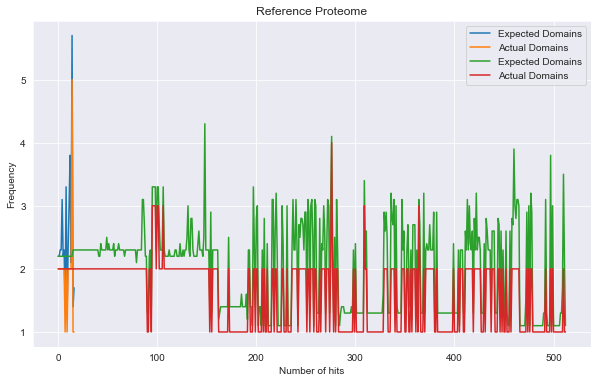

In [14]:
figure(figsize=(10, 6))

plt.plot(stats_rp_15['exp'].astype(float), label='Expected Domains')
plt.plot(stats_rp_15['N'].astype(float), label='Actual Domains')
plt.plot(stats_rp_75['exp'].astype(float), label='Expected Domains')
plt.plot(stats_rp_75['N'].astype(float), label='Actual Domains')

plt.xlabel('Number of hits')
plt.ylabel('Frequency')
plt.title('Reference Proteome')
plt.legend()

plt.show()

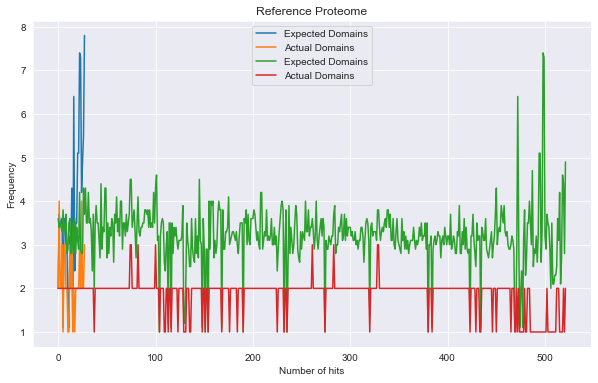

In [35]:
# Retrieve a query sequence
query_sequence = get_fasta(q_id)
query_lines = query_sequence.split("\n")
query_sequence = "".join(query_lines[1:])

In [124]:
# Retrieve the unaligned sequence from the local machine
rpalign = f'{local_path}results/alignments/fasta/{q_id}_rpalign.fasta'

with open(rpalign, 'w') as fout:
    # Write the query sequence to the output file as the first line
    fout.write(">{}\n{}\n".format(q_id, query_sequence))
    
    for index, row in stats_rp_15.iterrows():
        accession = row['Sequence']
        sequence = get_fasta(accession)
        if q_id == accession: # remove duplicates
            continue
        fout.write(sequence)

## 2. HHblits

HHblits is used for profile-profile sequence alignment. It compares a profile against a target sequence database to find homologous sequences.

In [ ]:
# HHblits against Pfam
!hhblits -i {align_file} -d {local_path}databases/pfam -o hhblits_pfam.txt # on alignment
# 1. RP instead of Pfam: align_file / RP
# 2. Pfam HMM / RP (both are already prepared files) - or just download Interpro and skip this step
# 3. Compare results (overlap) - or with Interpro (extract the rows by Uniprot ID and only after that filter by Pfam ID)

- `Hit`: contains information about Pfam identifier (starts with PF...), the abbreviated and full name of the domain.
- `Prob`: the probability of the match between the query sequence and the template sequence.
- `E-value`: the expected number of false positive matches that could occur by chance.
- `P-value`: the probability of obtaining a match with a score as good as or better than the observed score purely by chance.
Similar as `E-value`, the lower `P-value` indicate more significant matches.
- `Score`: the quality of the alignment between the query and template sequences.
- `SS (Secondary Structure)`: the predicted secondary structure of the aligned residues in the template sequence.
- `Cols`: the number of aligned columns or residues in the alignment between the query and template sequences.
- `Query HMM`: indicates position matches within HMM profile (input).
- `Template HMM`: indicates position matches within HMM profile (database).
Usually the length of template HMM is bigger than the length of query HMM.

In [ ]:
with open('hhblits_pfam.txt', 'r') as file:
    lines = file.readlines()

# Extract the column names
column_names = lines[8].split()[:-4] + ['Query HMM', 'Template HMM']

# Extract the data rows
data_rows = [line.split() for line in lines[9:19]] 
data_rows = [[row[0]] + [' '.join(row[1:4])] + row[7:14] + [' '.join(row[14:16])] 
             for row in data_rows]

# Create the DataFrame
hhblits_stats = pd.DataFrame(data_rows, columns=column_names)
hhblits_stats[["Hit", "Name"]] = hhblits_stats["Hit"].str.split(" ; ", expand=True)
print(f"The total number of HHblits hits on Pfam: {len(hhblits_stats)}, the number of unique domains: {hhblits_stats.Hit.nunique()}")
hhblits_stats

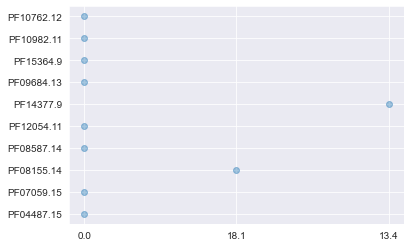

In [32]:
plt.scatter(hhblits_stats['Score'], hhblits_stats['Hit'], alpha=0.4)
plt.show()